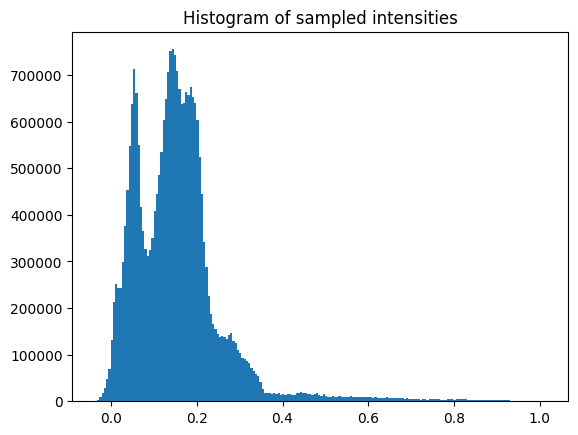

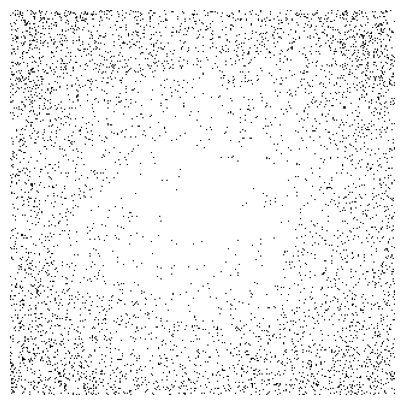

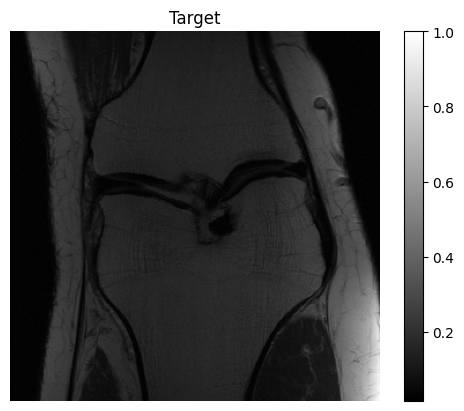

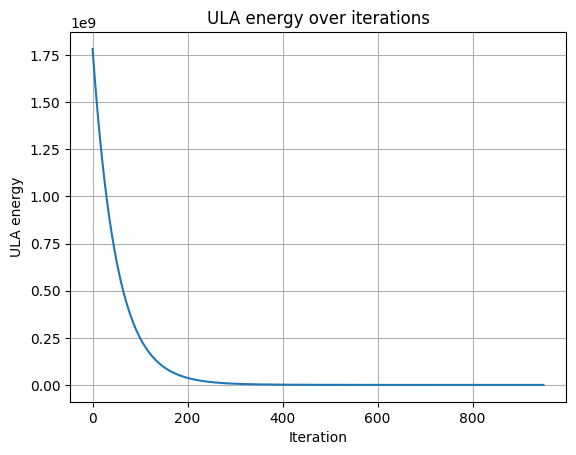

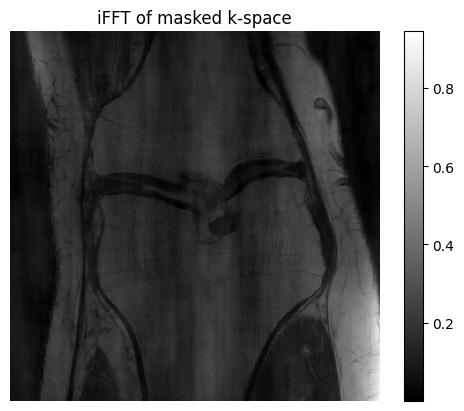

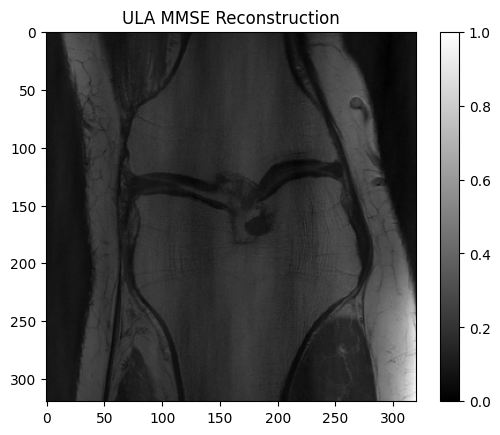

PSNR iFFT: 29.99 dB, NMSE iFFT: 0.0270, SSIM iFFT : 0.9000
None
PSNR ULA: 28.85 dB, NMSE ULA: 0.0351, SSIM ULA : 0.9216
None


In [4]:
# ULA diagnostics

import os
import sys
import fastmri
import fastmri.data
import fastmri.data.transforms
import h5py
import torch

# Set the path to the root of your project
project_root = os.path.abspath(os.path.join(os.getcwd(), r"C:\Users\kostanjsek\bachelor_project"))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import matplotlib.pyplot as plt
from utilities.masks import (
    CenteredBernoulliMask,
    UniformColumnMask,
    VariableDensityMask,
    PseudoRandomColumnMask,
    RadialMask
)
from fastmri.data import transforms as T
from utilities.metrics import psnr, nmse, mean_squared_error, ssim
from MAP.map_tv_minimize import MAPEstimator
from fastmri.data.mri_data import SliceDataset
from data.load_knee_mri import load_fastmri_data
from MMSE.mmse_ula import MMSEEstimatorULA
from MMSE.mmse_mala import MMSEEstimatorMALA
import skimage as ski


train_dataset, val_dataset, test_dataset = load_fastmri_data(
    r"C:\Users\kostanjsek\Documents\knee_mri"
)

file_name = r"C:\Users\kostanjsek\Documents\knee_mri\knee_singlecoil_train\singlecoil_train/file1000662.h5"
hf = h5py.File(file_name)

volume_kspace = hf['kspace'][()]
target = hf['reconstruction_rss'][()]

slice_kspace = volume_kspace[20]
slice_target = target[20]  # match slice index to kspace slice
tensor_kspace = T.to_tensor(slice_kspace)

slice_target = slice_target / np.abs(slice_target).max()

mask = VariableDensityMask('gaussian', 1.75, seed=30).generate(slice_target.shape)
#mask = PseudoRandomColumnMask(slice_target.shape, 2, 1, seed=30).get_mask()
#mask = CenteredBernoulliMask(0.75, 0.25, seed=30).generate(slice_target.shape)

y = mask * np.fft.fft2(slice_target, norm='ortho') # mask * slice_kspace
# y = y / np.abs(y).max()

#map_estimator = MAPEstimator(mask, 0.1, 0.01, 1e-2, 0.01, 300) # def-> 0.95, 0.01, 1e-2, 0.1, 100)
ula_estimator = MMSEEstimatorULA(mask, 0.001, 0.1, 5e-2, 1e-8, 450, 2, 250) # stepsize = 1e-2
#mala_estimator = MMSEEstimatorMALA(mask, 0.001, 2, 100e-2, 5e-11, 150, 2, 100)

#abs_err, rel_err = map_estimator.adjoint_test(slice_target.shape)
# print(abs_err, rel_err)

# x0 = np.real(mala_estimator.map_estimator.A_adj(y))
# mala_estimator.gradient_check(x0, y)
# mala_estimator.check_tv_grad()
# mala_estimator.energy_check(x0,y)
#map_reconstruct = map_estimator.subgradient_descent(y)
samples, energies = ula_estimator.ula_sampling(y)
mmse = ula_estimator.compute_mmse_estimate(samples)


# Fx = np.fft.fftshift(np.abs(np.fft.fft2(samples[-1])))

# plt.imshow(np.log1p(Fx), cmap='magma')
# plt.title("Log Fourier Magnitude of Last Sample")
# plt.colorbar()
# plt.show()

samples_array = np.array(samples)
plt.hist(samples_array.ravel(), bins=200)
plt.title("Histogram of sampled intensities")
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
#plt.title('Pseudo random (Gaussian 1D)')
plt.axis('off')
plt.show()

# plt.imshow(np.std(samples, axis=0), cmap="gray")
# plt.title("spatial uncertainty")
# plt.colorbar()
# plt.show()

# target
plt.imshow(slice_target / slice_target.max(), cmap="gray")
plt.title("Target")
plt.colorbar()
plt.axis("off")
plt.show()


# ula energy
plt.plot(energies)
plt.title("ULA energy over iterations")
plt.xlabel("Iteration")
plt.ylabel("ULA energy")
plt.grid(True)
#plt.yscale('log')
plt.show()

# ifft of y for comparison
plt.imshow(np.abs(np.fft.ifft2(y, norm='ortho')), cmap="gray")
plt.title("iFFT of masked k-space")
plt.colorbar()
plt.axis("off")
plt.show()

# ula mmse
plt.imshow(np.abs(mmse), cmap="gray")
plt.title("ULA MMSE Reconstruction")
plt.colorbar()
plt.show()

# plt.imshow(np.abs(mala_estimator.compute_mmse_estimate(y)), cmap="gray")
# plt.title("MALA MMSE Reconstruction")
# plt.colorbar()
# plt.show()

psnr_ifft = psnr(np.abs(np.fft.ifft2(y, norm='ortho')), slice_target)
nmse_ifft = nmse(np.abs(np.fft.ifft2(y, norm='ortho')), slice_target)
ssim_ifft = ssim(np.abs(np.fft.ifft2(y, norm='ortho')), slice_target)
print(print(f"PSNR iFFT: {psnr_ifft:.2f} dB, NMSE iFFT: {nmse_ifft:.4f}, SSIM iFFT : {ssim_ifft:.4f}"))

psnr_ula = psnr(mmse, slice_target)
nmse_ula = nmse(mmse, slice_target)
ssim_ula = ssim(mmse, slice_target)
print(print(f"PSNR ULA: {psnr_ula:.2f} dB, NMSE ULA: {nmse_ula:.4f}, SSIM ULA : {ssim_ula:.4f}"))

# psnr_mala = psnr(mala_estimator.compute_mmse_estimate(y), slice_target)
# print(print(f"PSNR MALA: {psnr_mala:.2f} dB"))

# nmse_mala = nmse(mala_estimator.compute_mmse_estimate(y), slice_target)
# print(print(f"NMSE MALA: {nmse_mala:.4f}"))

# print(f"Target diag.: max: {slice_target.max()}, min: {slice_target.min()}, mean: {np.mean(slice_target**2)}, std: {np.std(slice_target)}")


##################################################
# DIAGNOSTICS
##################################################

# H=320
# W=320
# xr = np.random.randn(H,W)
# d = np.random.randn(H,W)
# eps = 1e-6

# # analytic gradient used in ULA
# g_ula = ula_estimator.data_fidelity_gradient(xr, y) + ula_estimator.lambda_ * ula_estimator.huber_tv_subgradient(xr)
# ana = np.sum(g_ula * d)
# # numerical directional derivative of compute_loss
# E_plus  = ula_estimator.compute_loss(xr + eps*d, y)
# E_minus = ula_estimator.compute_loss(xr - eps*d, y)
# num = (E_plus - E_minus) / (2*eps)

# print("Full gradient test: analytic=", ana, " numeric=", num, " diff=", ana-num)

# for eps_fd in [1e-3, 5e-4, 1e-4, 5e-5]:
#     E_plus  = ula_estimator.compute_loss(xr + eps_fd*d, y)
#     E_minus = ula_estimator.compute_loss(xr- eps_fd*d, y)
#     num = (E_plus - E_minus) / (2*eps_fd)
#     diff = np.sum(g_ula * d) - num
#     print(f"eps={eps_fd:.0e}, diff={diff:.2f}")

# zero_image = np.zeros(slice_target.shape)
# plt.imshow(zero_image, cmap="gray")
# plt.title("zero image")
# plt.colorbar()
# plt.show()
# psnr_zero = psnr(zero_image, slice_target)
# print(print(f"PSNR zeros: {psnr_zero:.2f} dB"))